In [1]:
import pandas as pd

import shelve
import pickle

import scipy.io as sio
from scipy.sparse import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
ratingsFrame = pd.read_csv("ml-20m/csv/ratings.csv").loc[:,["userId", "movieId", "rating"]]
moviesFrame = pd.read_csv("ml-20m/csv/movies.csv").loc[:,["movieId"]]

In [21]:
# ratingsFrame.iloc[ratingsFrame.shape[0] - 1]["userId"]
# ratingsFrame.shape
# type(ratingsFrame.loc[1,"rating"])

#### movieId range:

In [5]:
moviesFrame.iloc[moviesFrame.shape[0] - 1]["movieId"]

131262

In [ ]:
ratingsFrame.sort_values(by = 'movieId', ascending=True, inplace=False).iloc[ratingsFrame.shape[0] - 1]["movieId"]

####  generate sparse matrix:

In [7]:
rating_matrix_lil = coo_matrix(([], ([], [])), shape=(138493 + 1, 131262 + 1)).tolil()
for index, row in ratingsFrame.iterrows():
    if index % 100000 == 0:
        print("%.2f%%" % (100 * index / ratingsFrame.shape[0]))  
    rating_matrix_lil[row["userId"], row["movieId"]] = row["rating"]

0.00%
0.50%
1.00%
1.50%
2.00%
2.50%
3.00%
3.50%
4.00%
4.50%
5.00%
5.50%
6.00%
6.50%
7.00%
7.50%
8.00%
8.50%
9.00%
9.50%
10.00%
10.50%
11.00%
11.50%
12.00%
12.50%
13.00%
13.50%
14.00%
14.50%
15.00%
15.50%
16.00%
16.50%
17.00%
17.50%
18.00%
18.50%
19.00%
19.50%
20.00%
20.50%
21.00%
21.50%
22.00%
22.50%
23.00%
23.50%
24.00%
24.50%
25.00%
25.50%
26.00%
26.50%
27.00%
27.50%
28.00%
28.50%
29.00%
29.50%
30.00%
30.50%
31.00%
31.50%
32.00%
32.50%
33.00%
33.50%
34.00%
34.50%
35.00%
35.50%
36.00%
36.50%
37.00%
37.50%
38.00%
38.50%
39.00%
39.50%
40.00%
40.50%
41.00%
41.50%
42.00%
42.50%
43.00%
43.50%
44.00%
44.50%
45.00%
45.50%
46.00%
46.50%
47.00%
47.50%
48.00%
48.50%
49.00%
49.50%
50.00%
50.50%
51.00%
51.50%
52.00%
52.50%
53.00%
53.50%
54.00%
54.50%
55.00%
55.50%
56.00%
56.50%
57.00%
57.50%
58.00%
58.50%
59.00%
59.50%
60.00%
60.50%
61.00%
61.50%
62.00%
62.50%
63.00%
63.50%
64.00%
64.50%
65.00%
65.50%
66.00%
66.50%
67.00%
67.50%
68.00%
68.50%
69.00%
69.50%
70.00%
70.50%
71.00%
71.50%
72.00%
72.50

In [8]:
save_npz('ml-latest/sparse_matrix_ml-latest.npz', rating_matrix_lil.tocsr())
rating_matrix_lil

<138494x131263 sparse matrix of type '<class 'numpy.float64'>'
	with 20000263 stored elements in LInked List format>

## Tag explore

In [9]:
import shelve
import pickle
d = shelve.open('tags_for_all_movie.pkl', protocol = pickle.HIGHEST_PROTOCOL)
tags_for_all_movie = d['content']
d.close()
movieId_empty = []
for movieId in tags_for_all_movie:
    if(tags_for_all_movie[movieId] == ""):
        movieId_empty.append(int(movieId))
len(movieId_empty)

4769

In [10]:
rating_matrix_csr[:,movieId_empty]

<270897x4769 sparse matrix of type '<class 'numpy.float64'>'
	with 26394 stored elements in Compressed Sparse Row format>

In [11]:
rating_matrix_csr[:,135145]

<270897x1 sparse matrix of type '<class 'numpy.float64'>'
	with 27 stored elements in Compressed Sparse Row format>

## Eliminate item with scarce info

### preview movies without ratings in rating dataset

In [3]:
movieId_list = list(moviesFrame.as_matrix().T[0])
movieId_list.remove(176279)

In [4]:
rating_matrix_csc = load_npz('ml-latest/sparse_matrix_ml-latest.npz').tocsc()
rating_matrix_csc = rating_matrix_csc[:, movieId_list]
rating_matrix_csc

<270897x45842 sparse matrix of type '<class 'numpy.float64'>'
	with 26024289 stored elements in Compressed Sparse Column format>

In [5]:
map_list = list(set(find(rating_matrix_csc)[1]))
map_list.sort()

In [6]:
movieId_list = moviesFrame.as_matrix().T[0]
del_list = list(movieId_list[list(set(list(range(0, 45842))) - set(map_list))])
del_list.append(176279)
len(del_list)

728

In [9]:
d = shelve.open('ml-latest/delete_movies_id_20M/delete_20M.pkl', protocol = pickle.HIGHEST_PROTOCOL)
deleteID_20m = d['content']
deleteID_20m = list(map(int, deleteID_20m))
d.close()
list(set(deleteID_20m) & set(del_list))

[151111, 112648, 169384, 169612, 169614, 169362, 169620, 169562, 104095]

In [124]:
d = shelve.open('ml-latest/empty_movies', protocol = pickle.HIGHEST_PROTOCOL)
d['content'] = del_list
d.close()

### delete specified

In [111]:
rating_matrix_lil = load_npz('ml-latest/sparse_matrix_ml-latest.npz').tolil()
rating_matrix_lil

<270897x176276 sparse matrix of type '<class 'numpy.float64'>'
	with 26024289 stored elements in LInked List format>

In [112]:
d = shelve.open('ml-latest/delete_movies_id_20M/delete_20M.pkl', protocol = pickle.HIGHEST_PROTOCOL)
deleteID_20m = d['content']
d.close()
deleteID_20m = list(map(int, deleteID_20m))
rating_matrix_lil[:,deleteID_20m]

<270897x644 sparse matrix of type '<class 'numpy.float64'>'
	with 1773 stored elements in LInked List format>

In [113]:
rating_matrix_lil[:,deleteID_20m] = 0
rating_matrix_lil

<270897x176276 sparse matrix of type '<class 'numpy.float64'>'
	with 26022516 stored elements in LInked List format>

### compress matrix

In [114]:
map_list = list(set(find(rating_matrix_lil)[1]))
map_list.sort()

In [115]:
del rating_matrix_lil
rating_matrix_csc = load_npz('ml-latest/sparse_matrix_ml-latest.npz').tocsc()
rating_matrix_csc

<270897x176276 sparse matrix of type '<class 'numpy.float64'>'
	with 26024289 stored elements in Compressed Sparse Column format>

In [116]:
rating_matrix_csc = rating_matrix_csc[1:,map_list]
rating_matrix_csc

<270896x44480 sparse matrix of type '<class 'numpy.float64'>'
	with 26022516 stored elements in Compressed Sparse Column format>

In [118]:
save_npz('ml-latest/sparse_matrix_ml-latest_selected.npz', rating_matrix_csc)
d = shelve.open('ml-latest/map_list_ml-latest', protocol = pickle.HIGHEST_PROTOCOL)
d['content'] = map_list
d.close()

## convert to mat

In [48]:
rating_matrix_csc = load_npz('ml-latest/sparse_matrix_ml-latest_selected.npz').tocsc()
sio.savemat('../Step 2 - User Clustering/data/sparse_matrix_ml-latest.mat', {'UI_matrix': rating_matrix_csc})

In [50]:
d = shelve.open('ml-latest/map_list_ml-latest', protocol = pickle.HIGHEST_PROTOCOL)
map_list = d['content'] 
d.close()
sio.savemat('../Step 2 - User Clustering/data/map_list_ml-latest.mat', {'map_list': map_list})

## data explore

In [3]:
rating_matrix_csc = load_npz('ml-latest/sparse_matrix_ml-latest_selected.npz')

items = rating_matrix_csc[:, 0:rating_matrix_csc.shape[1]].getnnz(axis=0).tolist()
users = rating_matrix_csc[0:rating_matrix_csc.shape[0], :].getnnz(axis=1).tolist()

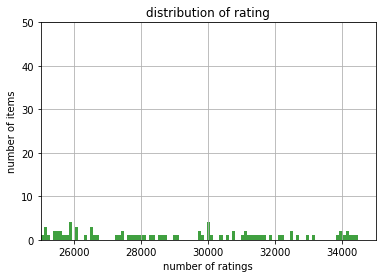

In [4]:
n, bins, patches = plt.hist(np.array(items), 1000, facecolor='g',cumulative=False, alpha=0.75)

plt.xlabel('number of ratings')
plt.ylabel('number of items')
plt.title('distribution of rating')
plt.axis([25000, 35000, 0, 50])
plt.grid(True)
plt.show()

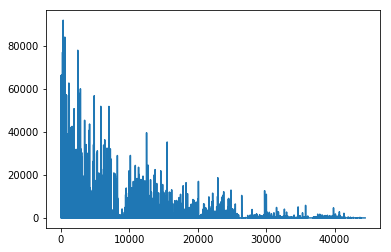

In [5]:
plt.plot(items)
plt.show()

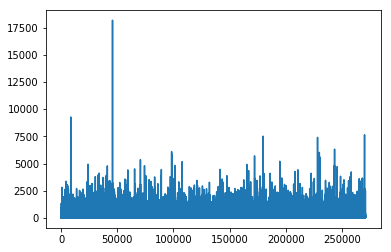

In [6]:
plt.plot(users)
plt.show()

In [2]:
d = shelve.open('ml-latest/map_list_ml-latest', protocol = pickle.HIGHEST_PROTOCOL)
map_list = d['content']
d.close()

In [6]:
map_list[65 - 1]

65